# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import copy
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder  
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pprint #Data pretty printer

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
feat_info


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [4]:
feat_info.groupby('missing_or_unknown')['missing_or_unknown'].nunique() #what all missing or unknown charaters we have to watch out for

missing_or_unknown
[-1,0,9]    1
[-1,0]      1
[-1,9]      1
[-1,XX]     1
[-1,X]      1
[-1]        1
[0]         1
[XX]        1
[]          1
Name: missing_or_unknown, dtype: int64

In [5]:
azdias.head(5)
#azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
#To Replace missing or unknown values with NaN
for ind, row in feat_info.iterrows():
    attribute = row['attribute']
    missing_codes_str = row['missing_or_unknown']
    X = 'X'
    XX = 'XX'
    # For parsing string list to list
    missing_codes = eval(missing_codes_str)
    #replacing values
    for missing_code in missing_codes:
        azdias[attribute] = azdias[attribute].replace(missing_code, np.NaN)
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [7]:
# Perform an assessment of how much missing data there is in each column of the dataset.
missing = azdias.isnull().sum(axis = 0) #counting Nulls in each column
#columns with most missing values (top 10)
top10 = missing.replace(0,np.nan).dropna(how='all',axis=0).sort_values(ascending=False).head(10)
total_datapoints = azdias.shape[0]
top10 = ((top10/total_datapoints)*100).round(decimals=2)  

#Sorted Values to identify if any pattern in Missing Values
missing.sort_values(ascending=False)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

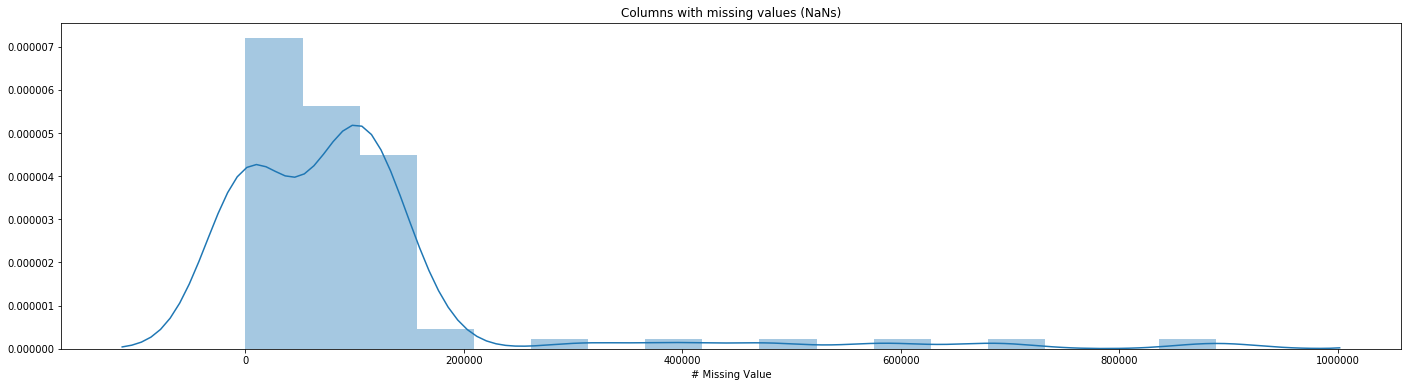

In [8]:
# Investigate patterns in the amount of missing data in each column.

#Distribution of Missing Values
plt.figure(figsize=(24,6))
sns.distplot(missing)
plt.title("Columns with missing values (NaNs)")
plt.xlabel("# Missing Value")
plt.show() 


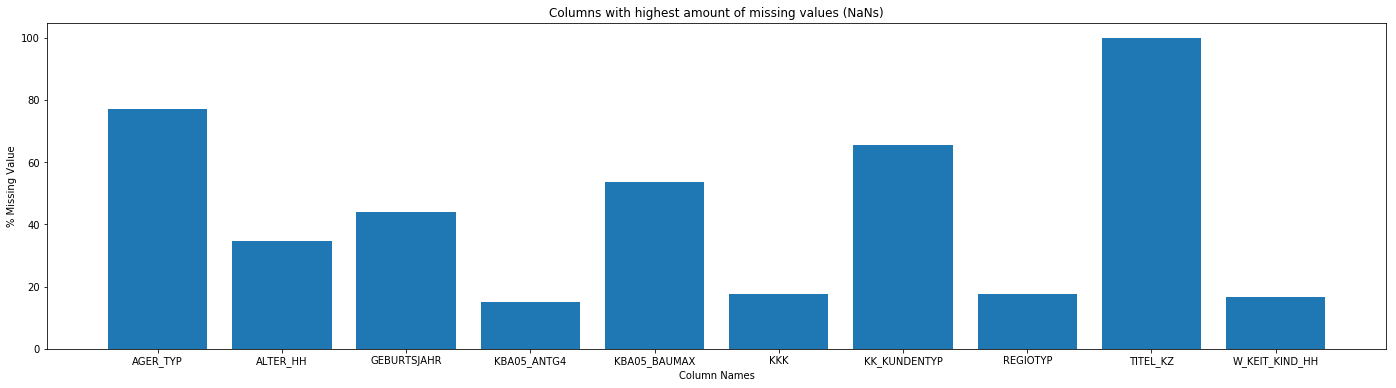

In [9]:
#plotting a bar plot with column name in x axis and count of NaNs in Y-axis of Top 10 columns with highest missing data
plt.figure(figsize=(24,6))
plt.bar(top10.index, top10.values)
plt.title("Columns with highest amount of missing values (NaNs)")
plt.ylabel("% Missing Value")
plt.xlabel("Column Names")
plt.show() 

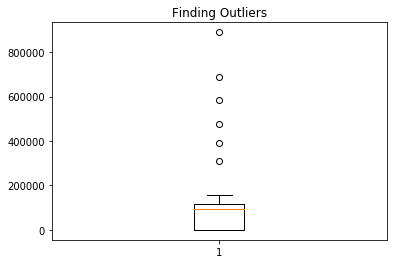

In [10]:
#Box Plot to look for Outliers
plt.boxplot(missing.values)
plt.title("Finding Outliers")
plt.show()

In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
lis = []
for i in range(85):
    if missing.values[i] > 200000:
        lis.append(str(missing.index[i]))
print("columns to be dropped: ",lis)
azdias.drop(lis, axis=1,inplace=True)

columns to be dropped:  ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


#### Discussion 1.1.2: Assess Missing Data in Each Column
I sorted the Missing Values in Azdias column and found that there are groups of Columns closely related like 'PLZ8' having same number of Missing Values each. 

Upon plotting the Distribution plot, it was found that most of the columns have 0 to 200000 missing data points, with higher amounts being uniformly distributed. 

After Analysing the Missing Values in Bar Plot and Box plot we were able to identify Six columns with maximum Missing Values. Six outliers (['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']) Columns with huge (>200,000) missing data points are dropped before proceeding further, based on the above analysis. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [12]:
# How much data is missing in each row of the dataset?
missing_row = azdias.isnull().sum(axis = 1) 
missing_row.sort_values(ascending=False) #data points missing in each row 

643174    49
732775    49
472919    48
183108    47
139316    47
691141    47
691142    47
691171    47
691183    47
139332    47
691197    47
139323    47
691212    47
691122    47
139267    47
139255    47
139250    47
139248    47
139245    47
139243    47
691317    47
691129    47
691118    47
139236    47
139478    47
690871    47
690876    47
690878    47
690887    47
139521    47
          ..
540246     0
540244     0
540243     0
540242     0
540241     0
540240     0
540239     0
540269     0
540271     0
540300     0
540289     0
540299     0
540298     0
540296     0
540295     0
540293     0
540292     0
540291     0
540290     0
540287     0
540273     0
540286     0
540284     0
540283     0
540281     0
540280     0
540277     0
540275     0
540274     0
445610     0
Length: 891221, dtype: int64

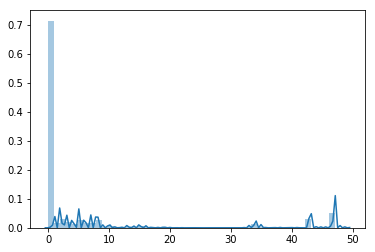

In [13]:
#Distribution of Missing Values in Rows
sns.distplot(missing_row)
plt.show()

Choosing 10 as threshold, as it can be see in the Distribution plot there is a large gap between 10 and 31 no. of missing values.

In [14]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 10

Average_missing =  sum(missing_row)/azdias.shape[0]
print(Average_missing)

#dividing data into two subsets based on the missing values in each row
few_missVal = azdias[azdias.isnull().sum(axis=1) < threshold].reset_index(drop=True) #less than threshold missing
high_missVal = azdias[azdias.isnull().sum(axis=1) >= threshold].reset_index(drop=True) #greater than threshold missing

5.64989379739


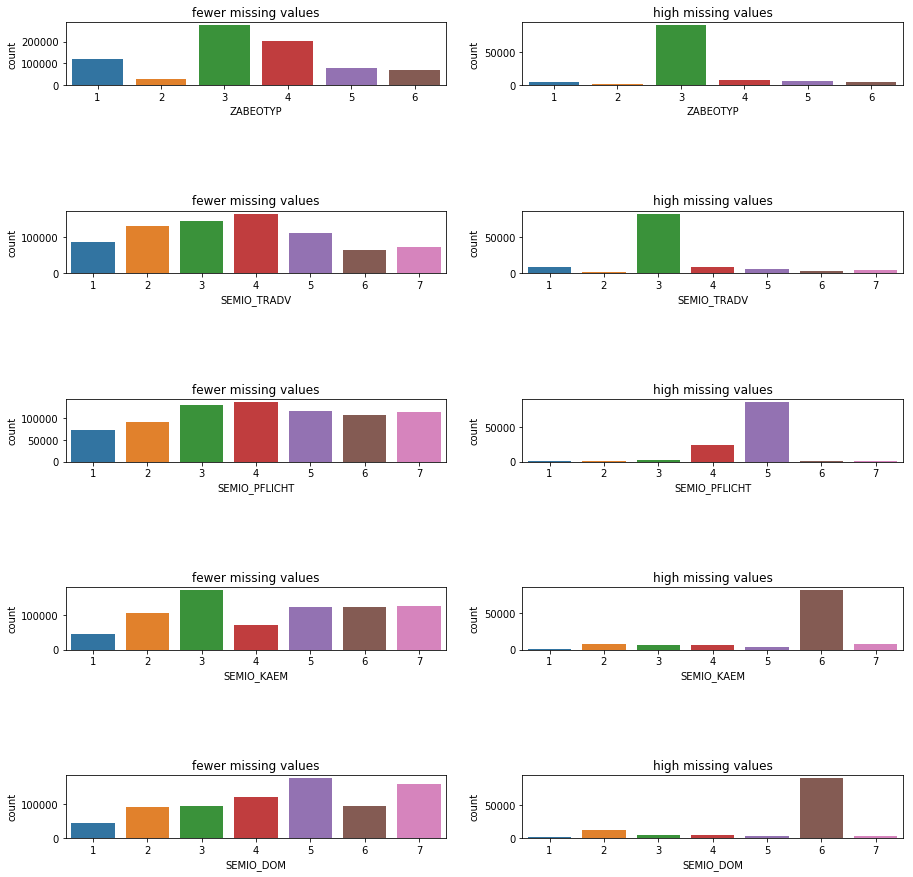

In [15]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
col_names = missing.sort_values(ascending=True).head(5).index #are five columns chosen which has no missing values 

def countplot(cols,num):
    
    fig, axs = plt.subplots(num,2, figsize=(15, 15), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace =2 , wspace=.2)
    axs = axs.ravel()

    for i in range(num):
    
        sns.countplot(few_missVal[cols[i]], ax=axs[i*2])
        axs[i*2].set_title('fewer missing values')
        
        sns.countplot(high_missVal[cols[i]], ax=axs[i*2+1])
        axs[i*2+1].set_title('high missing values')
    
    
countplot(col_names,5)

#### Discussion 1.1.3: Assess Missing Data in Each Row
10 as a threshold was selected to divide the data into two subsets after analysing the distplot of Missing Values in rows.

After comparing distribution of data on rows with high missing Values to that with few missing values for certain columns, it can be seen that the 'distribution of missing values is quite different' amongst the groups/subsets. The data points with high missing values are lesser in columns. 

On an Average 5.65 data points are missing in each row. Highest amount of missing data values is 49 and lowest being 0. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [16]:
# How many features are there of each data type?
feat_info['attribute'].groupby(feat_info['type']).nunique() #types of measurement

type
categorical    21
interval        1
mixed           7
numeric         7
ordinal        49
Name: attribute, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [17]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#we will be using few_missing data (data with fewer number of NaNs in row), selected as per above analysis
#Categorical Columns List
categorical_columns = [cols for cols in feat_info[feat_info['type']=="categorical"]['attribute']]
#Mixed Columns List
mixed_columns = [cols for cols in feat_info[feat_info['type']=="mixed"]['attribute']]

binary_catcols = []
multi_catcols = []
rencode = [] 
for cols in categorical_columns:
    if cols in few_missVal.columns:
        if few_missVal[cols].nunique() == 2:
            #print(few_missing[cols].unique()) -> shows one Binary column need to be rencoded 
            binary_catcols.append(cols)
        else:
            multi_catcols.append(cols)

print("Binary Columns:\n",binary_catcols)
print("\nMulti-Level Columns:\n",multi_catcols)

#One Binary and all Multi-Level Columns need to be encoded 
rencode = copy.copy(multi_catcols)
rencode.append('OST_WEST_KZ')
print("\n{} columns need encoding".format(len(rencode)))

Binary Columns:
 ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

Multi-Level Columns:
 ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']

14 columns need encoding


In [18]:
# Re-encode categorical variable(s) to be kept in the analysis.

#function for one_hot encoding
def one_hot(df, col):
    for each in col:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=True)
        df = pd.concat([df, dummies], axis=1)
    return df

few_missVal = few_missVal.drop(multi_catcols,axis=1) #dropping column with Multi-level categories
        
# Encoding the Binary column with non-numeric values
few_missVal = one_hot(few_missVal,['OST_WEST_KZ'])
few_missVal = few_missVal.drop('OST_WEST_KZ',axis=1)
    

few_missVal.head(1)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_W
0,1.0,2,1,5,2,5,4,5,0,3.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1


#### Discussion 1.2.1: Re-Encode Categorical Features

Dealing with data having few missing values (obtained from above analysis, after dropping the missing value columns); we found 18 categorical columns in our data, 5 of which were Binary and 13 were Multi-Level Categorical Columns. 
Of 5 Binary columns only 1 had Non-Numeric Value and hence was one hot encoded, after which the original column was dropped. 
Of 13 Multi-Level Categorical columns, first I tried to one-hot encode and drop original columns but that quickly made the count of columns to over 900, which I thought may not be appropriate, and to keep things straightforward, I decided to drop the columns. 
Final count of columns is 66 after re-encoding/dropping categorical values. 

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [19]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables
few_missVal.groupby("PRAEGENDE_JUGENDJAHRE")["PRAEGENDE_JUGENDJAHRE"].count().sort_values(ascending = True)

PRAEGENDE_JUGENDJAHRE
7.0       3939
13.0      5520
2.0       7387
1.0      20106
4.0      20185
12.0     23925
6.0      25311
9.0      32939
11.0     34385
15.0     40803
3.0      52758
5.0      83112
10.0     83394
8.0     137903
14.0    177574
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

We have Values ranging from 1 to 15 in this column with 14 being the most common occuring value. 

In [20]:
#Total no. of Nulls
few_missVal["PRAEGENDE_JUGENDJAHRE"].isnull().sum() 

25502

In [21]:
#Filling Nulls with most common value found above
few_missVal["PRAEGENDE_JUGENDJAHRE"] = few_missVal["PRAEGENDE_JUGENDJAHRE"].fillna(14)

In [22]:
#Engineering two new features; Decades and Movement
def decades_interval(x):
    if x in (1,2):
        return 1
    if x in (3,4):
        return 2
    if x in (5,6,7):
        return 3
    if x in (8,9):
        return 4
    if x in (10,11,12,13):
        return 5
    if x in (14,15):
        return 6
    
def binary_movement(x):
    if x in (2,4,6,7,9,11,13,15):
        return 0
    if x in (1,3,5,8,10,12,14):
        return 1
    

few_missVal['decade'] = few_missVal['PRAEGENDE_JUGENDJAHRE'].apply(decades_interval)
few_missVal['movement'] = few_missVal['PRAEGENDE_JUGENDJAHRE'].apply(binary_movement)

In [23]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
few_missVal.groupby("CAMEO_INTL_2015")["CAMEO_INTL_2015"].count()

CAMEO_INTL_2015
12     12795
13     25477
14     60994
15     16645
22     31990
23     24111
24     88559
25     38587
31     17721
32     10087
33      9571
34     18111
35     10139
41     90430
43     55429
44     14502
45     25610
51    132086
52     20258
54     44745
55     23440
Name: CAMEO_INTL_2015, dtype: int64

Values ranges from 12 to 55 (which seems to be divided into specific interval, confirmed by Data Dictionary). 51 is the most common value

In [24]:
#Total no. of Nulls
few_missVal["CAMEO_INTL_2015"].isnull().sum() 

3456

In [25]:
#Filling Nulls with most common value found above
few_missVal["CAMEO_INTL_2015"] = few_missVal["CAMEO_INTL_2015"].fillna(51)

In [26]:
#Engineering two new features; Wealth and Stages
def wealthiness(x):
    x = int(x)
    if x // 10 ==1:
        return 1
    if x // 10 ==2:
        return 2
    if x // 10 ==3:
        return 3
    if x // 10 ==4:
        return 4
    if x // 10 ==5:
        return 5
    
def life_stages(x):
    x = int(x)
    if x % 10 ==1:
        return 1
    if x % 10 ==2:
        return 2
    if x % 10 ==3:
        return 3
    if x % 10 ==4:
        return 4
    if x % 10 ==5:
        return 5
    

few_missVal['wealth'] = few_missVal['CAMEO_INTL_2015'].apply(wealthiness)
few_missVal['stages'] = few_missVal['CAMEO_INTL_2015'].apply(life_stages)

In [27]:
#Dropping the rest of Mixed Columns
for cols in mixed_columns:
    if cols in few_missVal.columns:
        few_missVal.drop(cols, axis=1, inplace=True)
few_missVal.shape

(774743, 64)

#### Discussion 1.2.2: Engineer Mixed-Type Features

The two suggested mixed type columns, were rencoded into 4 new columns ('decade', 'movement', 'wealth' and 'stages').The missing values in original columns ('PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015') was replaced with the most frequently occuring value identified and the columns ('PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015') were deleted from the data frame (few_missVal Data frame having fewer missing values). I checked the other 5 mixed columns and either there weren't enough levels to disentangle different values or there was way to much value to represent, so I decided to drop them off, leaving the total columns count to be 65. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [28]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
few_missVal.describe()
few_missVal.isnull().sum().sort_values(ascending=False) 
sum(few_missVal.isnull().sum()) #Amount of missing data points still left; will be dealt later

452522

In [29]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#just an extra check to make sure columns are right
feat_types = {'categorical':0,'unknown':0,'mixed':0,'numeric':0,'ordinal':0,'interval':0}

for cols in few_missVal:
    a = str(feat_info[feat_info["attribute"] == cols]["type"].values)
    if "ordinal" in a:
        feat_types['ordinal'] +=1  
    elif "categorical" in a:
        feat_types['categorical'] +=1 
    elif "numeric" in a:
        feat_types['numeric'] +=1 
    elif "interval" in a:
        feat_types['interval'] +=1 
    elif "mixed" in a:
        feat_types['mixed'] +=1 
    else: 
        feat_types['unknown'] += 1 #should account for engineered features
       

 #checking if all types account for total no. of columns 
print("Types of Features (columns we have left):\n",feat_types)
s = 0 
for k,v in feat_types.items():
    s += v
if s == few_missVal.shape[1]:
    print("All checks done")

Types of Features (columns we have left):
 {'categorical': 4, 'unknown': 5, 'mixed': 0, 'numeric': 6, 'ordinal': 49, 'interval': 0}
All checks done


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [30]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for ind, row in feat_info.iterrows():
        attribute = row['attribute']
        missing_codes_str = row['missing_or_unknown']
        X = 'X'
        XX = 'XX'
        # For parsing string list to list
        missing_codes = eval(missing_codes_str)
        #replacing values
        for missing_code in missing_codes:
            df[attribute] = df[attribute].replace(missing_code, np.NaN)
    
    
    # remove selected columns and rows, ...
    drop_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'] #obtain using previous analysis
    df.drop(drop_columns,axis=1,inplace=True)
    df = df[df.isnull().sum(axis=1) < threshold].reset_index(drop=True) #less than threshold missing
    
    # select, re-encode, and engineer column values.
    df = df.drop(multi_catcols,axis=1) # dropping column with Multi-level categories
    df = one_hot(df,['OST_WEST_KZ'])   # Encoding the Binary column with non-numeric values
    df = df.drop('OST_WEST_KZ',axis=1)
    
    #rencoding
    df["PRAEGENDE_JUGENDJAHRE"] = df["PRAEGENDE_JUGENDJAHRE"].fillna(14)
    df['decade'] = df['PRAEGENDE_JUGENDJAHRE'].apply(decades_interval)
    df['movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(binary_movement)
    
    df["CAMEO_INTL_2015"] = df["CAMEO_INTL_2015"].fillna(51)
    df['wealth'] = df['CAMEO_INTL_2015'].apply(wealthiness)
    df['stages'] = df['CAMEO_INTL_2015'].apply(life_stages)
    
    for cols in mixed_columns: #Dropping the rest of Mixed Columns
        if cols in df.columns:
            df.drop(cols, axis=1, inplace=True)

    #this step is performed below (later for previous dataframe)
    miss_col = []
    for col in df.columns:
        nullcount = df[col].isnull().sum()
        if nullcount > 0:
            miss_col.append(col)
    for cols in miss_col: #replacing NaNs for column not dropped with most occuring value
        df[cols].fillna(df[cols].mode()[0], inplace=True)

    # Return the cleaned dataframe.
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [31]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
miss_cols = [] #to capture columns with missing values
maxi = 0 
coli = ""
for col in few_missVal.columns:
    nullcount = few_missVal[col].isnull().sum()
    if nullcount > 0:
        miss_cols.append(col)
        if nullcount > maxi:
            maxi = nullcount
            coli = col

print("Columns with Null: ",miss_cols)
print("\n#Columns: ",len(miss_cols))
print("\nColumn with Max Null: {} have {}".format(coli,maxi))

Columns with Null:  ['ALTERSKATEGORIE_GROB', 'HEALTH_TYP', 'VERS_TYP', 'W_KEIT_KIND_HH', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB']

#Columns:  29

Column with Max Null: W_KEIT_KIND_HH have 55257


In [32]:
#using mode to fill Missing columns
for cols in miss_cols:
    few_missVal[cols].fillna(few_missVal[cols].mode()[0], inplace=True)


In [33]:
sum(few_missVal.isnull().sum()) #All nulls treated

0

In [34]:
# Apply feature scaling to the general population demographics data.
sc = StandardScaler() 
few_missVal[few_missVal.columns] = sc.fit_transform(few_missVal[few_missVal.columns].as_matrix())

In [35]:
few_missVal.head() #normalized features

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_W,decade,movement,wealth,stages
0,-1.765558,0.958422,-1.488785,1.540017,-1.044684,1.468541,0.981043,1.327209,-0.531136,1.007436,...,1.435587,0.563825,-0.179238,-0.132956,0.679358,0.519166,1.106006,0.531136,1.170872,-1.249876
1,0.198811,0.958422,-1.488785,0.867244,-1.770775,-0.568811,0.263375,1.327209,1.882757,1.007436,...,0.405294,0.563825,-0.179238,-0.132956,-0.795816,0.519166,1.106006,-1.882757,-0.874330,0.763676
2,1.180995,0.958422,0.689233,-0.478302,1.133590,-0.568811,-1.171961,-0.818216,-0.531136,-0.315096,...,-0.625000,0.563825,-1.183153,-1.003767,-0.058229,0.519166,-0.259273,0.531136,-1.556065,-0.578692
3,0.198811,-1.043381,0.689233,0.194471,0.407498,-1.247929,0.263375,-0.818216,-0.531136,1.007436,...,-0.625000,-0.339744,0.824677,0.302450,1.416945,0.519166,-0.259273,0.531136,0.489138,0.092492
4,-1.765558,0.958422,-0.036773,-1.151076,1.133590,-0.568811,-0.454293,1.327209,-0.531136,1.007436,...,1.435587,1.467394,-1.183153,-1.003767,-0.058229,0.519166,-1.624552,0.531136,1.170872,0.763676


### Discussion 2.1: Apply Feature Scaling

I had around 1.6 lakh missing data points; since we have already handled Mixed and Categorical columns, the missing value columns were only Numeric, Ordinal or Interval type.After investigating a few columns I decided to replace the value with most occuring value in the colume (i.e. mode). Finally we obtained Few_missVal dataframe with zero missing values.
On this dataframe Standard Scaler was applied to normalize the value and perform feature scaling (as suggested) 



### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [36]:
# Apply PCA to the data.
pca = PCA()
pca.fit_transform(few_missVal)

array([[  3.94287484e+00,  -2.50941203e+00,  -2.90584741e+00, ...,
         -1.41015125e-01,  -1.40070285e-01,   8.21422095e-13],
       [ -9.45627286e-01,   2.54758509e-01,  -3.07158988e+00, ...,
          3.70643340e-02,   8.71164592e-02,   2.64956376e-13],
       [ -3.86498775e+00,   1.30783359e+00,  -6.99073489e-01, ...,
         -2.32303508e-01,  -6.63508023e-01,  -3.06217122e-13],
       ..., 
       [ -8.37374128e-01,  -3.24160235e+00,  -2.89516576e+00, ...,
          1.37365371e-01,  -1.22812293e-01,   2.16389059e-16],
       [  5.86469385e+00,  -3.21253943e+00,   2.35905139e+00, ...,
         -2.91409690e-01,   1.13154411e-01,   6.08078966e-16],
       [ -8.14031503e-01,   9.91845880e-01,   3.08443220e+00, ...,
         -5.63769292e-01,  -1.98122725e-01,   1.75737038e-16]])

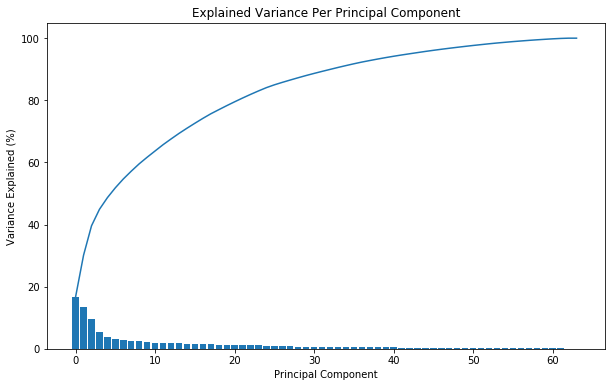

In [37]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pcaplot):
    # Creates a scree plot associated with the principal components 

    num_components = len(pca.explained_variance_ratio_)
    
    x = np.arange(num_components)
    y = pca.explained_variance_ratio_
    y = y*100
    
    plt.figure(figsize=(10, 6))
    
    cumulative_val = np.cumsum(y)
    
    plt.bar(x, y)
    plt.plot(x, cumulative_val)
    
    
    plt.xlabel("Principal Component")
    plt.ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')



scree_plot(pca)

In [38]:
# Re-apply PCA to the data while selecting for number of components to retain.
few_missPCA = PCA(n_components=10)
few_missData = few_missPCA.fit_transform(few_missVal) #Dataset to work on Later

### Discussion 2.2: Perform Dimensionality Reduction

I decided to retain 10 Principal Components, as more than 50% of the Variance is explained by 10 components and also the Scree plot kinds of taper off after that.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [39]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def map_weights(pca,i): #the required function
    pca_weights = {}
    for counter, feature in enumerate(few_missVal):
        pca_weights[feature] = pca.components_[i][counter]
    pca_weights = sorted(pca_weights.items(), key=lambda kv: kv[1], reverse=True) #Sort in descending order
    return pca_weights

#weights for first Prinicpal Component
weights = map_weights(few_missPCA,1) 
pprint.pprint(weights)

[('ALTERSKATEGORIE_GROB', 0.25722495612516283),
 ('SEMIO_ERL', 0.23025417759575592),
 ('FINANZ_VORSORGER', 0.22977073092585229),
 ('SEMIO_LUST', 0.18000608429735329),
 ('RETOURTYP_BK_S', 0.16349360292987489),
 ('FINANZ_HAUSBAUER', 0.11889673202390377),
 ('SEMIO_KRIT', 0.11871669907257754),
 ('SEMIO_KAEM', 0.11514248974398417),
 ('W_KEIT_KIND_HH', 0.11393776515465977),
 ('PLZ8_ANTG3', 0.098399511075235979),
 ('EWDICHTE', 0.096010473895016935),
 ('ORTSGR_KLS9', 0.09473343065384919),
 ('PLZ8_ANTG4', 0.093253500391249536),
 ('ANREDE_KZ', 0.092438463505413737),
 ('wealth', 0.077355872154323185),
 ('KBA05_ANTG4', 0.073472689014576667),
 ('SEMIO_DOM', 0.072392682784168993),
 ('ARBEIT', 0.069854493219824176),
 ('PLZ8_ANTG2', 0.067880270755262984),
 ('RELAT_AB', 0.067580490766794288),
 ('ANZ_HAUSHALTE_AKTIV', 0.064610361476840614),
 ('FINANZ_MINIMALIST', 0.062148609513888155),
 ('HH_EINKOMMEN_SCORE', 0.058101213490348851),
 ('WOHNDAUER_2008', 0.057502086962190155),
 ('KBA05_ANTG3', 0.0483726356

In [40]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

#weights for second Prinicpal Component
weights = map_weights(few_missPCA,2) 
pprint.pprint(weights)

[('SEMIO_VERT', 0.3459843209678774),
 ('SEMIO_SOZ', 0.26289634572258591),
 ('SEMIO_FAM', 0.24923714439123137),
 ('SEMIO_KULT', 0.23293179380960971),
 ('FINANZ_MINIMALIST', 0.15541708228267354),
 ('RETOURTYP_BK_S', 0.1098395613011561),
 ('FINANZ_VORSORGER', 0.10092898500617735),
 ('W_KEIT_KIND_HH', 0.085306318533333134),
 ('ALTERSKATEGORIE_GROB', 0.079530194391214573),
 ('SEMIO_REL', 0.068826800232995949),
 ('SEMIO_LUST', 0.064362998992403581),
 ('SEMIO_MAT', 0.05492381928850925),
 ('ORTSGR_KLS9', 0.049798821740764165),
 ('EWDICHTE', 0.049135935768050532),
 ('GREEN_AVANTGARDE', 0.048511462233128917),
 ('PLZ8_ANTG3', 0.048383755445325728),
 ('PLZ8_ANTG4', 0.048121827983198751),
 ('ARBEIT', 0.036308205245094219),
 ('RELAT_AB', 0.033527063360448181),
 ('PLZ8_ANTG2', 0.032559036540380983),
 ('WOHNDAUER_2008', 0.03237130644530628),
 ('KBA05_ANTG4', 0.029303611597709452),
 ('wealth', 0.028971414906274157),
 ('ANZ_HAUSHALTE_AKTIV', 0.02622089033678917),
 ('ANZ_HH_TITEL', 0.013690095805686441),

In [41]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

#weights for third Prinicpal Component
weights = map_weights(few_missPCA,3) 
pprint.pprint(weights)

[('GREEN_AVANTGARDE', 0.39882540407293071),
 ('EWDICHTE', 0.26020847024797977),
 ('ORTSGR_KLS9', 0.24699660268689164),
 ('PLZ8_HHZ', 0.13749215873412049),
 ('ONLINE_AFFINITAET', 0.13661488919405942),
 ('SEMIO_DOM', 0.1156962445549935),
 ('OST_WEST_KZ_W', 0.11216850196421527),
 ('PLZ8_ANTG2', 0.1085478025035054),
 ('ANZ_PERSONEN', 0.10227163212961607),
 ('PLZ8_ANTG3', 0.10068923854741228),
 ('KBA05_ANTG1', 0.10066310539488196),
 ('RELAT_AB', 0.095440759490049293),
 ('FINANZ_UNAUFFAELLIGER', 0.081854520810486844),
 ('PLZ8_ANTG4', 0.080714763164287648),
 ('SEMIO_KAEM', 0.077490687837540484),
 ('MOBI_REGIO', 0.068626848720744635),
 ('SEMIO_TRADV', 0.062714568439368928),
 ('FINANZ_MINIMALIST', 0.062229089249106063),
 ('stages', 0.061259055772053907),
 ('KBA05_GBZ', 0.055976069720979939),
 ('SEMIO_RAT', 0.055080735495688295),
 ('ARBEIT', 0.050986293482857881),
 ('ANZ_TITEL', 0.048722329682127571),
 ('KBA13_ANZAHL_PKW', 0.048134903908371204),
 ('ANREDE_KZ', 0.038108808485727834),
 ('ANZ_HH_TI

### Discussion 2.3: Interpret Principal Components

Positive values from the firtst few principal components surely do show a positive correlation. Principal Component one and two both gives high weightage to Person Level Features, and these features are most closely related in Prinicpal component two where the top three weighted features are- 'SEMIO_VERT', 'SEMIO_SOZ' and 'SEMIO_FAM'each representing a Personality Typlology(Dreamful, Socially Minded and Family Minded); while the features are most dispersed/varying in Prinicpal components three. 

Negative Values 'SEMIO_DOM' & 'SEMIO_KAEM' in Principal component two both have the high negative weights & clearly the high corelation, where one indicate Dominant Mind and other Combative Attitude. Same holds true for 'HH_EINKOMMEN_SCORE' & 'KKK' features where one indicate the high household income and the other net purchasing power in the region.

Now comparing the Positive weight with Negative; 'ALTERSKATEGORIE_GROB' (representing Age) and 'SEMIO_REL' (representing Religion) both have high weight in Principal component one but different sign indicating no correlation, both are on the opposite side of the spectrum which makes sense as Relgion has nothing to do with age. Same hold true for feature like 'FINANZ_ANLEGER' & 'FINANZ_MINIMALIST' one with high negative and other with high positive weight in Principal Component two, where one indicates an Investor and other a Minimalist. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [42]:
# Over a number of different cluster counts...

#defining the kmeans function to calculate score
def Kmeans(data,clusters):
    kmeans_cluster = KMeans(n_clusters=clusters)
    
    # run k-means clustering on the data and...
    model = kmeans_cluster.fit(data)
    
    
    # compute the average within-cluster distances.
    score = np.abs(model.score(data))
    
    return score


scores = []
clusters = list(range(4,30,2))

for cluster in clusters:
    scores.append(Kmeans(few_missData, cluster))

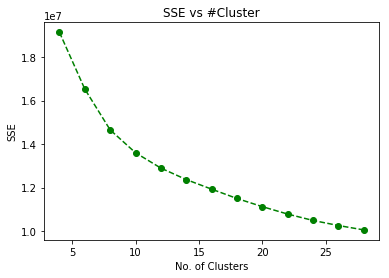

In [44]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(clusters, scores, linestyle='--', marker='o', color='g')
plt.xlabel('No. of Clusters')
plt.ylabel('SSE')
plt.title('SSE vs #Cluster')
plt.show()

In [45]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=10)
model = kmeans.fit(few_missData)
general_clusters = model.predict(few_missData)

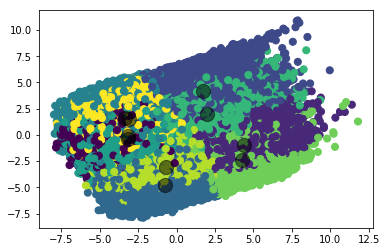

In [46]:
#Trying to visualize the clusters - its high dimensional data, so visualization is not accurate
plt.scatter(few_missData[:, 0], few_missData[:, 1], c=general_clusters, s=50, cmap='viridis') #uses first and second PCA components

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

### Discussion 3.1: Apply Clustering to General Population

I tried from 4 to 30 clusters. After plotting the scores against number of clusters, I found 10 being the right amount of clusters, where the graph sort of makes an elbow. Then 10 was used to predict on the General Demographics data.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [47]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [48]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
clean_customers = clean_data(customers)

In [49]:
#Feature scaling
clean_customers[clean_customers.columns] = sc.transform(clean_customers[clean_customers.columns].as_matrix())

#PCA
customers_pca = few_missPCA.transform(clean_customers)

#Clustering
customers_clusters = model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

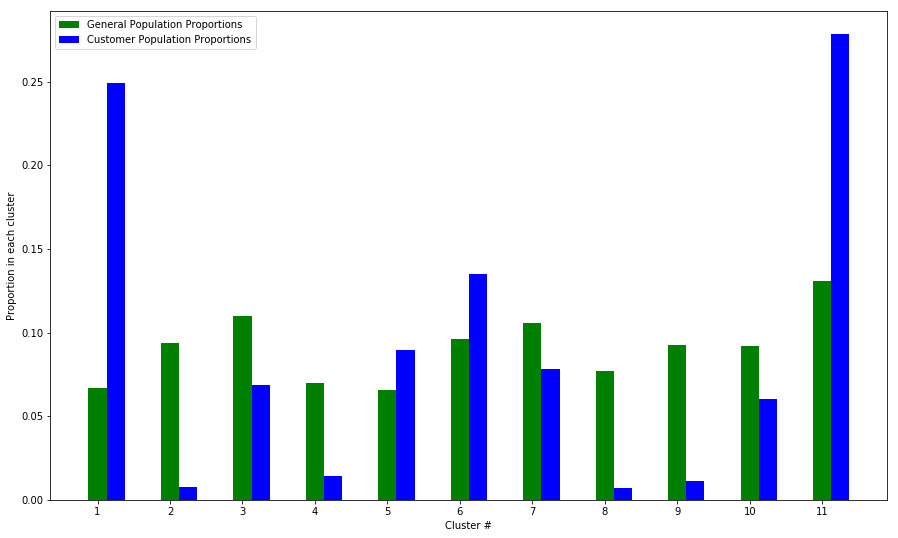

In [62]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

generalProportion = []
customerProportion = []

#Comparing high missing values data of step 1.1.3 as a separate cluster (separate bar graph) #cluster 11
high_missGeneral = high_missVal
high_missCustomers = customers[customers.isnull().sum(axis=1) > threshold].reset_index(drop=True)
hg_count = high_missGeneral.shape[0]
hc_count = high_missCustomers.shape[0]

#Clustering Proportion Plot
X1 = [i+1 for i in range(11)]
X2 = [x+0.25 for x in X1]
tot_g = len(general_clusters)+hg_count
tot_c = len(customers_clusters)+hc_count

for i in range(10):
    generalProportion.append((general_clusters == i).sum()/tot_g)
    customerProportion.append((customers_clusters == i).sum()/tot_c)

generalProportion.append(hg_count/tot_g)
customerProportion.append(hc_count/tot_c)


plt.figure(figsize=(15,9))
plt.bar(X1,generalProportion,color='g',width=0.25)
plt.bar(X2,customerProportion,color='b',width=0.25)
plt.ylabel('Proportion in each cluster')
plt.xlabel('Cluster #')
plt.xticks(np.arange(1,12,1))
plt.legend(['General Population Proportions','Customer Population Proportions'])
plt.show()

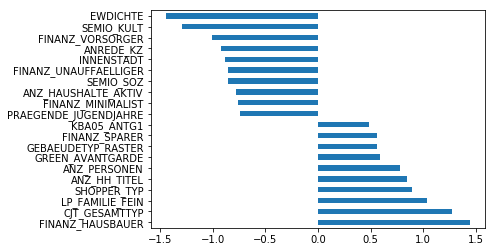

In [64]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

#comparision plot
def plot_scaled_comparison(df, kmeans, cluster):
    X = pd.DataFrame.from_dict(dict(zip(df.columns,
                                        few_missPCA.inverse_transform(kmeans.cluster_centers_[cluster]))), 
                                        orient='index').rename(
                                        columns={0: 'feature_values'}).sort_values('feature_values', ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh');
    

#cluster 1
plot_scaled_comparison(customers, model, 0)

In [58]:
#Further investigation

#Inversing Data
cd = customers_pca[np.where(customers_clusters==2)] #customer pca data for the cluster
pca_inv = few_missPCA.inverse_transform(cd)
data = sc.inverse_transform(pca_inv)
datar = data.round()

index = np.array(range(0, data.shape[0]))

dfc1 = pd.DataFrame(data=datar, index=index, columns=clean_customers.columns)

print("shape of Dataframe ",dfc1.shape)
dfc1.head(10)

shape of Dataframe  (45477, 64)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_W,decade,movement,wealth,stages
0,4.0,1.0,5.0,0.0,5.0,0.0,2.0,2.0,1.0,1.0,...,5.0,5.0,2.0,3.0,2.0,1.0,2.0,0.0,1.0,4.0
1,4.0,1.0,4.0,2.0,4.0,1.0,2.0,2.0,1.0,2.0,...,5.0,5.0,3.0,6.0,3.0,1.0,3.0,0.0,2.0,4.0
2,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,2.0,...,5.0,5.0,2.0,4.0,2.0,1.0,3.0,0.0,1.0,4.0
3,4.0,1.0,5.0,0.0,5.0,0.0,1.0,2.0,1.0,1.0,...,3.0,3.0,3.0,5.0,3.0,1.0,2.0,-0.0,2.0,4.0
4,3.0,1.0,5.0,2.0,3.0,2.0,3.0,1.0,1.0,3.0,...,5.0,5.0,3.0,6.0,3.0,1.0,5.0,-0.0,2.0,4.0
5,3.0,1.0,5.0,1.0,4.0,1.0,2.0,2.0,1.0,2.0,...,3.0,4.0,2.0,3.0,2.0,1.0,3.0,0.0,1.0,4.0
6,3.0,1.0,5.0,1.0,4.0,1.0,2.0,2.0,1.0,1.0,...,5.0,5.0,2.0,5.0,2.0,1.0,3.0,-0.0,1.0,4.0
7,3.0,1.0,6.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,3.0,4.0,2.0,4.0,2.0,1.0,3.0,-0.0,1.0,4.0
8,3.0,1.0,5.0,3.0,3.0,3.0,3.0,1.0,1.0,2.0,...,6.0,5.0,2.0,5.0,2.0,1.0,5.0,0.0,2.0,3.0
9,3.0,1.0,4.0,2.0,4.0,1.0,3.0,2.0,1.0,1.0,...,4.0,3.0,3.0,7.0,3.0,1.0,4.0,-0.0,3.0,3.0


In [60]:
#General Population
gd = few_missData[np.where(general_clusters==2)] #customer pca data for the cluster
pca_inv = few_missPCA.inverse_transform(gd)
data = sc.inverse_transform(pca_inv)
datar = data.round()

index = np.array(range(0, data.shape[0]))

dfg1 = pd.DataFrame(data=datar, index=index, columns=few_missVal.columns)

print("shape of Dataframe ",dfg1.shape)
dfg1.head(10)

shape of Dataframe  (56893, 64)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_W,decade,movement,wealth,stages
0,3.0,1.0,4.0,3.0,3.0,2.0,3.0,2.0,1.0,3.0,...,3.0,3.0,3.0,5.0,3.0,1.0,5.0,0.0,2.0,3.0
1,3.0,1.0,4.0,2.0,4.0,1.0,3.0,3.0,1.0,3.0,...,4.0,4.0,3.0,7.0,3.0,1.0,4.0,0.0,2.0,3.0
2,3.0,1.0,3.0,3.0,3.0,2.0,3.0,2.0,1.0,3.0,...,4.0,3.0,4.0,9.0,4.0,1.0,5.0,0.0,3.0,3.0
3,3.0,1.0,5.0,2.0,3.0,3.0,2.0,2.0,1.0,2.0,...,4.0,4.0,3.0,5.0,3.0,1.0,4.0,0.0,3.0,3.0
4,3.0,1.0,4.0,2.0,4.0,3.0,3.0,2.0,1.0,2.0,...,5.0,5.0,2.0,4.0,2.0,1.0,4.0,0.0,2.0,4.0
5,4.0,1.0,4.0,2.0,4.0,2.0,2.0,2.0,1.0,3.0,...,4.0,4.0,3.0,7.0,3.0,1.0,4.0,0.0,3.0,3.0
6,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,3.0,3.0,4.0,6.0,4.0,1.0,3.0,0.0,3.0,3.0
7,3.0,1.0,5.0,2.0,4.0,1.0,3.0,1.0,1.0,3.0,...,3.0,3.0,3.0,7.0,3.0,1.0,4.0,0.0,2.0,3.0
8,3.0,1.0,5.0,3.0,3.0,3.0,3.0,1.0,1.0,2.0,...,3.0,4.0,2.0,3.0,2.0,1.0,5.0,0.0,1.0,4.0
9,4.0,1.0,6.0,0.0,5.0,1.0,1.0,2.0,1.0,2.0,...,4.0,5.0,3.0,5.0,2.0,1.0,3.0,0.0,1.0,4.0


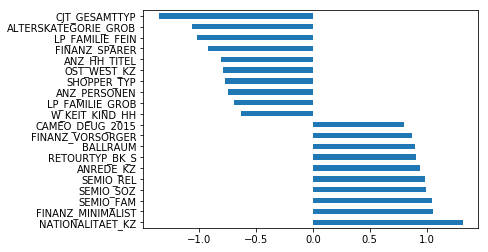

In [65]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

plot_scaled_comparison(customers, model, 1) #cluster 2

In [66]:
#Further investigation
cd = customers_pca[np.where(customers_clusters==6)] #customer pca data for the cluster
pca_inv = few_missPCA.inverse_transform(cd)
data = sc.inverse_transform(pca_inv)
datar = data.round()

index = np.array(range(0, data.shape[0]))

dfc = pd.DataFrame(data=datar, index=index, columns=clean_customers.columns)

print("shape of Dataframe ",dfc.shape)
dfc.head(10)

shape of Dataframe  (14746, 64)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_W,decade,movement,wealth,stages
0,3.0,1.0,3.0,3.0,4.0,3.0,3.0,2.0,-0.0,3.0,...,3.0,3.0,2.0,5.0,3.0,1.0,5.0,1.0,4.0,1.0
1,3.0,1.0,4.0,1.0,5.0,1.0,1.0,4.0,-0.0,2.0,...,4.0,4.0,2.0,4.0,2.0,1.0,3.0,1.0,4.0,3.0
2,3.0,1.0,3.0,2.0,4.0,1.0,2.0,4.0,0.0,3.0,...,4.0,2.0,3.0,9.0,4.0,1.0,4.0,1.0,4.0,2.0
3,4.0,1.0,4.0,0.0,5.0,-0.0,0.0,4.0,1.0,2.0,...,3.0,2.0,3.0,8.0,3.0,1.0,2.0,0.0,3.0,3.0
4,3.0,1.0,3.0,1.0,5.0,1.0,1.0,4.0,-0.0,2.0,...,3.0,2.0,2.0,6.0,2.0,1.0,3.0,1.0,4.0,2.0
5,4.0,1.0,4.0,1.0,5.0,2.0,1.0,4.0,-0.0,1.0,...,3.0,3.0,4.0,5.0,4.0,0.0,2.0,1.0,5.0,3.0
6,4.0,1.0,4.0,2.0,4.0,2.0,2.0,3.0,0.0,2.0,...,5.0,5.0,3.0,5.0,3.0,1.0,4.0,1.0,4.0,3.0
7,4.0,1.0,4.0,1.0,5.0,1.0,1.0,4.0,-0.0,2.0,...,3.0,3.0,3.0,5.0,4.0,1.0,2.0,1.0,5.0,2.0
8,4.0,1.0,4.0,1.0,5.0,1.0,1.0,3.0,-0.0,2.0,...,4.0,3.0,3.0,6.0,4.0,1.0,3.0,1.0,5.0,1.0
9,3.0,1.0,4.0,1.0,5.0,0.0,2.0,4.0,1.0,2.0,...,4.0,3.0,3.0,7.0,4.0,1.0,3.0,0.0,3.0,3.0


In [67]:
gd = few_missData[np.where(general_clusters==6)] #customer pca data for the cluster
pca_inv = few_missPCA.inverse_transform(gd)
data = sc.inverse_transform(pca_inv)
datar = data.round()

index = np.array(range(0, data.shape[0]))

dfg = pd.DataFrame(data=datar, index=index, columns=few_missVal.columns)

print("shape of Dataframe ",dfg.shape)
dfg.head(10)

shape of Dataframe  (94474, 64)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_W,decade,movement,wealth,stages
0,3.0,1.0,4.0,2.0,4.0,2.0,2.0,2.0,0.0,3.0,...,3.0,3.0,3.0,7.0,4.0,1.0,4.0,1.0,4.0,2.0
1,2.0,1.0,2.0,2.0,4.0,1.0,2.0,4.0,-0.0,2.0,...,3.0,2.0,3.0,7.0,3.0,1.0,4.0,1.0,5.0,2.0
2,2.0,1.0,3.0,2.0,4.0,0.0,2.0,4.0,0.0,3.0,...,3.0,0.0,2.0,10.0,2.0,1.0,4.0,1.0,4.0,2.0
3,3.0,1.0,3.0,2.0,4.0,1.0,2.0,4.0,0.0,2.0,...,4.0,3.0,4.0,9.0,5.0,1.0,3.0,1.0,5.0,2.0
4,4.0,1.0,4.0,1.0,5.0,1.0,1.0,3.0,-0.0,2.0,...,3.0,3.0,3.0,4.0,3.0,1.0,3.0,1.0,4.0,2.0
5,3.0,1.0,3.0,3.0,4.0,2.0,2.0,3.0,-0.0,3.0,...,5.0,4.0,4.0,7.0,4.0,1.0,4.0,1.0,4.0,2.0
6,3.0,1.0,3.0,2.0,4.0,1.0,2.0,4.0,0.0,2.0,...,4.0,4.0,3.0,6.0,3.0,1.0,3.0,1.0,3.0,3.0
7,3.0,1.0,3.0,3.0,4.0,2.0,3.0,4.0,0.0,2.0,...,5.0,4.0,3.0,5.0,3.0,1.0,4.0,1.0,4.0,2.0
8,4.0,1.0,3.0,1.0,5.0,1.0,1.0,4.0,-0.0,2.0,...,4.0,3.0,4.0,8.0,4.0,1.0,3.0,1.0,5.0,2.0
9,3.0,1.0,2.0,3.0,4.0,2.0,3.0,4.0,0.0,2.0,...,4.0,3.0,2.0,5.0,3.0,1.0,4.0,1.0,4.0,2.0


### Discussion 3.3: Compare Customer Data to Demographics Data

According to my Analysis, Segment of the population relatively popular with mail-order company is more of Old people, Investors/Financially well and Living in region with Low unemployment having High to Average Purchasing power and owing the house. They are weathy and financially stable individuals which are members of green avantgarde. This is due to the features of GREEN_AVANTGARDE (membership in environmental sustainability - The avant-garde are people or works that are experimental, radical, or unorthodox with respect to art, culture, or society). They have there own home (indicated by presence of feature 'FINANZ_HAUSBAUER' with high weight).

While segment of the population unpopular with mail-order company is more of Young People, Financially Minimalist and Living in region with High unemployment having Average Purchasing power.They lack Financial Stability. Also there analysis doesn't indicate presence of 'GREEN_AVANTGARDE' or 'FINANZ_HAUSBAUER' features with weightage.  

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.